# Capstone 2: Preprocessing and Training
<b>PROJECT GOAL</b><br>
The overall goal of this project is to understand and predict a time series on delinquency rate (response variable) for lease contracts originated by U.S. banks.  Time series for several predictor (exogenous) variables will be included in an attempt to identify economic variables that may help explain and thus predict future lease delinquency rates.<br>

<b>DATA</b><br>
<i>all series have been converted to quarterly data as of each calendar quarter end</i><br>

<i>response variable</i><br>
'delinq' = Lease Delinquency Rate, all banks; www.federalreserve.gov/datadownload/)<br><br>
<i>predictor (exogenous) variables (features)</i><br>
'ls_rcvbl' = Lease Receivable Balance, all banks; www.federalreserve.gov/datadownload/)<br>
'pmi_man' = ISM Purchasing Managers Index (PMI); www.quandl.com/data/ISM/MAN_PMI-PMI-Composite-Index<br>
'cons_sent' = Univ of Michigan Index of Consumer Sentiment; www.sca.isr.umich.edu/tables.html <br>
'close_price' = S&P 500 Price Index; finance.yahoo.com<br>
'stdtght_ci_smll_netpct' = Loan Standard Tightening, net percentage, commerical and industrial loans from small banks; www.federalreserve.gov/datadownload/)<br>
'tot_bus_inv' = Total Business Inventories; www.census.gov/economic-indicators/ <br>
'ret_sales' = Retail Sales; www.census.gov/economic-indicators/ <br>

<b>PREPROCESSING AND TRAINING NOTEBOOK</b><br>
The purpose of this notebook is to:
<ol type="1">
    <li>Partition the data into training and testing subsets.</li>
    <li>Fit baseline ARIMA(p,1,q) models by cross validation on the training data.</li>
    <li>Fit ARIMA(p,1,q) models with exogenous (features) variables by cross-validation on the training data.</li>
    <li>Identify the best features (exogenous) variables in ARIMA(p,1,q) models for predicting lease delinquency rate.</li>
    <li>Visualize the best-fit models versus the training and test data and test the best models on the test data. </li>
</ol> 

The methodology follows the time series and regression methods in Hyndman and Athanasopoulos 2021 (hereafter, [HA 2021]).

<i>References</i><br>
Hyndman, R.J., & Athanasopoulos, G. (2021) Forecasting: principles and practice, 3rd edition, OTexts: Melbourne, Australia. OTexts.com/fpp3.

## 1 Import Python Modules, Load Data, Define Train, Test Data
### <b>1.1 Import Python Modules </b>

In [1]:
import pandas as pd
import numpy as np
import itertools as it
import statsmodels.api as sm
import pmdarima as pm
from pmdarima.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

### <b>1.2 Load Data </b>
Load data that continues from the Exploratory Data Analysis notebook.

In [2]:
filnm01 = '../data/delinq_transformed_subsets.pkl'

with open(filnm01, 'rb') as f:
    data_objects = pickle.load(f)
    
subset_meta = data_objects[0]
row_subsets = data_objects[1]
df_subsets = data_objects[2]
df_ln_subsets = data_objects[3]
df_lndif01_subsets = data_objects[4]

### <b>1.3 Define Train, Test Data Sets</b>

Train, test data split follows [HA 2021, section 5.10]:
<ol type="1">
   <li>The natural-log transformed data containing all responses variables are used, so the series starts at 1992-Q1, ends at 2021-Q1, and contains 117 records (117 is the number of records in the shortest series).</li>
  <li>The test data are the last 4 quarters {2020-Q2, 2020-Q3, 2020-Q4, 2021-Q1}, which would cover a large forecast window from a business use case perspective.  The most useful and practical business case is to forecast one quarter forward.</li>
  <li>The training data are the preceding 113 quarters, {1992-Q1, 1992-Q2, ..., 2020-Q1}.</li>
</ol> 

In [3]:
#Define dataframes for train, test
df_full = df_subsets[2]
df_train, df_test = train_test_split(df_subsets[2], test_size=4)
df_ln_full = df_ln_subsets[2]
df_ln_train, df_ln_test = train_test_split(df_ln_subsets[2], test_size=4)
print('train data record count:',df_ln_train['delinq'].count())
print(df_ln_train['delinq'].head(4),df_ln_train['delinq'].tail(4))
print('test data record count:',df_ln_test['delinq'].count())
print(df_ln_test['delinq'].tail(4))

train data record count: 113
date_qtr
1992Q1    0.779325
1992Q2    0.788457
1992Q3    0.783902
1992Q4    0.737164
Freq: Q-DEC, Name: delinq, dtype: float64 date_qtr
2019Q2    0.086178
2019Q3    0.148420
2019Q4    0.231112
2020Q1    0.246860
Freq: Q-DEC, Name: delinq, dtype: float64
test data record count: 4
date_qtr
2020Q2    0.425268
2020Q3    0.371564
2020Q4    0.364643
2021Q1    0.392042
Freq: Q-DEC, Name: delinq, dtype: float64


## 2 Baseline ARIMA(p,1,q) Model
### <b>2.1 Fit ARIMA(p,1,q) Model without Exogenous Variables as a Baseline Model</b>

<ol type="1">
   <li>Lease delinquency rate data are natural-log transformed and first differenced (d=1) based on the results of the time series diagnostics implemented in the Exploratory Data Analysis (EDA) notebook.  In the EDA notebook, the first-differenced delinquency rate data are stationary with mean very close to zero and the partial autocorrelation plots indicated potential autocorrelation up to lag 8.</li>
  <li>Autocorrelation and Moving Average parameters (p,q) are fit to the lease delinquency rate series over lags ranging from 0 to 8 (based on EDA results) with d=1, so ARIMA models of the form (p,1,q) with no intercept (stationary mean of zero) are fit to the training data. </li>
  <li>Cross validation (CV) follows [HA 2021, section 5.10] and is implemented with pmdarima.model_selection.RollingForecastCV.</li>
  <li>In the cross validation, the smallest training window (fold) is 65 quarters, covering {1992-Q1,...,2008-Q1}, which covers about 55% of the training set and ends just before the large increase in delinquency rate arising from the 2008 recession.  Both the forecast window and subsequent increments to fold size in RollingForecastCV are 4 quarters in length, matching the size of the test data set. There are 16 total rolling forecast windows for a total of 48 quarters, {2008-Q2,...,2020-Q1}.</li>
  <li>Models are scored using average mean squared error (MSE), with the average (mean) taken over folds.  AIC and BIC model selection criteria are also calculated, in these cases using the full training data series for each parameter set.</li>
</ol>

In [4]:
#score results [iteration, intercept, p, q, score_mean, score_std]
base_arima_cv_res = []

#parameter grids
intcpt_lst01 = [False]
p_lst01 = [i for i in range(9)]
q_lst01 = [i for i in range(9)]

#cross-validation folds
cvset_base_arima_model = pm.model_selection.RollingForecastCV(h=4, step=4, initial=65)

#loop over parameters, cross-validate
ct01 = 0
for int01 in intcpt_lst01:
    for p01 in p_lst01:
        for q01 in q_lst01:
            #status
            ct01 = ct01 + 1
            if ct01 % 5 == 0:
                print('iteration:',ct01,int01,p01,q01)    
            
            #arima model (p,1,q), with_intercept = int01
            base_arima_model = pm.ARIMA(order=(p01, 1, q01), with_intercept=int01, scoring='mse', maxiter=20, suppress_warnings=True)
            #cross validation
            cv_scor_base_arima_model = pm.model_selection.cross_validate(base_arima_model, df_ln_train['delinq'], scoring='mean_squared_error', cv=cvset_base_arima_model, verbose=0)
            #fit full training data
            base_arima_model.fit(df_ln_train['delinq'])
            
            #results
            scor_mean01 = np.mean(cv_scor_base_arima_model['test_score'])
            scor_std01 = np.std(cv_scor_base_arima_model['test_score'])
            aic01 = base_arima_model.aic()
            bic01 = base_arima_model.bic()
            base_arima_cv_res.append([ct01, int01, p01, q01, scor_mean01, scor_std01, aic01, bic01])

#save results in dataframe
df_base_arima_cv_res = pd.DataFrame(base_arima_cv_res) 
df_base_arima_cv_res.columns = ['iteration', 'intercept', 'p', 'q', 'mse_mean', 'mse_std', 'aic', 'bic']

iteration: 5 False 0 4
iteration: 10 False 1 0
iteration: 15 False 1 5
iteration: 20 False 2 1
iteration: 25 False 2 6
iteration: 30 False 3 2
iteration: 35 False 3 7
iteration: 40 False 4 3
iteration: 45 False 4 8
iteration: 50 False 5 4
iteration: 55 False 6 0
iteration: 60 False 6 5
iteration: 65 False 7 1
iteration: 70 False 7 6
iteration: 75 False 8 2
iteration: 80 False 8 7


### <b>2.2 Baseline Models Cross Validation: Table Summary Sorted by Best CV Score </b><br>
<li>Each row is the cross validation result of the best-fit (p,q) parameter values indicated.</li>
<li>Column 'mse_mean' is the mean MSE, with the mean taken over folds.</li>
<li>AIC, BIC scores for each model are shown as well, calculated on the full training data set.</li>
<li>Rows are sorted by column 'mse_mean_rk' - the rank of 'mse_mean' over the best-fit parameter sets - in ascending order.</li>

In [5]:
#rank by mse, aic, bic
df_base_arima_cv_res.loc[:,'mse_mean_rk'] = df_base_arima_cv_res.loc[:,'mse_mean'].rank(axis=0,ascending=True)
df_base_arima_cv_res.loc[:,'aic_rk'] = df_base_arima_cv_res.loc[:,'aic'].rank(axis=0,ascending=True)
df_base_arima_cv_res.loc[:,'bic_rk'] = df_base_arima_cv_res.loc[:,'bic'].rank(axis=0,ascending=True)

#print top 15
df_base_arima_cv_res.sort_values('mse_mean_rk').head(15)

,iteration,intercept,p,q,mse_mean,mse_std,aic,bic,mse_mean_rk,aic_rk,bic_rk
37,38,False,4,1,0.023045,0.035809,-195.383819,-179.072826,1.0,55.0,25.0
36,37,False,4,0,0.023056,0.035931,-197.328194,-183.735700,2.0,43.0,14.0
20,21,False,2,2,0.023073,0.035862,-196.788552,-183.196057,3.0,47.0,16.0
30,31,False,3,3,0.023094,0.035189,-193.951212,-174.921720,4.0,63.0,33.0
28,29,False,3,1,0.023150,0.035847,-197.324216,-183.731721,5.0,44.0,15.0
39,40,False,4,3,0.023165,0.035663,-191.923693,-170.175702,6.0,77.0,49.0
27,28,False,3,0,0.023208,0.035813,-198.825336,-187.951341,7.0,31.0,8.0
19,20,False,2,1,0.023259,0.035809,-198.639630,-187.765635,8.0,34.0,10.0
3,4,False,0,3,0.023268,0.035256,-199.378726,-188.504731,9.0,24.0,7.0
18,19,False,2,0,0.023288,0.035806,-200.245456,-192.089960,10.0,18.0,1.0


### <b>2.3 Baseline Models Cross Validation: Plot Mean MSE vs Rank Mean MSE</b><br>
   <li>Plot of mean MSE ('mse_mean') versus rank of mean MSE ('mse_mean_rk'), as defined above.</li>

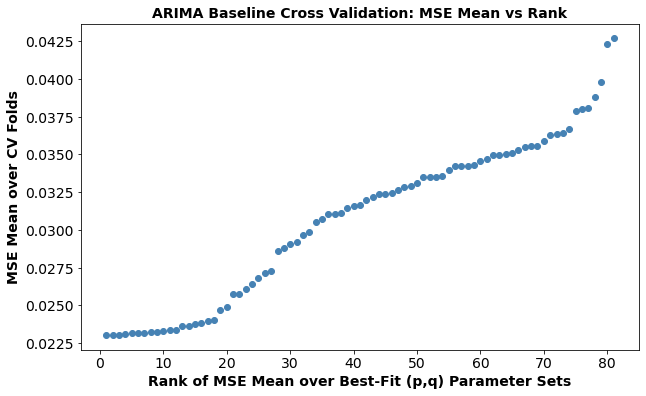

In [6]:
#Plot model selection scores (mse_mean vs rank)
fig01, axes01 = plt.subplots(nrows=1,ncols=1,figsize=(10,6))

#line plot
df_base_arima_cv_res.plot(ax=axes01,x='mse_mean_rk',y='mse_mean',style="o",markersize=6.0,color='steelblue')
    
axes01.set_title('ARIMA Baseline Cross Validation: MSE Mean vs Rank', fontsize = 14.0, fontweight='bold')
axes01.set_xlabel('Rank of MSE Mean over Best-Fit (p,q) Parameter Sets', fontsize = 14.0, fontweight='bold')
axes01.tick_params(axis='x', labelsize=14)
axes01.set_ylabel('MSE Mean over CV Folds', fontsize = 14.0, fontweight='bold') 
axes01.tick_params(axis='y', labelsize=14)
axes01.get_legend().remove()


### <b><font color='blue'> Interpretation: Baseline Models </font></b>
The 12 best models are very similiar in terms of cross validation score.  The best CV model is a 5-parameter model of the form ARIMA(4,1,1) and the best BIC model, which ranks 10 in terms of CV score, is a 2-parameter model of the form ARIMA(2,1,0). If the 2-parameter model is nearly as good as the 5-parameter model, it makes sense to use the simpler model, because this is just the baseline model and later in the analysis I want to also potentially include several predictor (feature) variables as exogenous variables in the time series model.

### <b>2.4 Baseline Models Cross Validation: Summary of Best Model by CV Score</b>

In [7]:
#CV score: best parameters
idx01 = df_base_arima_cv_res[df_base_arima_cv_res['mse_mean_rk']==1.0].index[0]
int01 = df_base_arima_cv_res.loc[idx01,'intercept']
p01 = df_base_arima_cv_res.loc[idx01,'p']
q01 = df_base_arima_cv_res.loc[idx01,'q']

#Fit model
base_arima_model = pm.ARIMA(order=(p01, 1, q01), with_intercept=int01, scoring='mse', maxiter=20, suppress_warnings=True)
base_arima_model.fit(df_ln_train['delinq'])     
base_arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  113
Model:               SARIMAX(4, 1, 1)   Log Likelihood                 103.692
Date:                Wed, 14 Jul 2021   AIC                           -195.384
Time:                        23:51:36   BIC                           -179.073
Sample:                             0   HQIC                          -188.766
                                - 113                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0489      1.496      0.033      0.974      -2.882       2.980
ar.L2          0.2546      0.248      1.025      0.305      -0.232       0.741
ar.L3          0.0962      0.344      0.279      0.780      -0.579       0.771
ar.L4         -0.0640      0.150     -0.427      0.669      -0.358       0.230
ma.L1          0.0978      1.493      0.065      0.948      -2.828       3.024
sigma2         0.0091      0.001      7.573      0.000       0.007       0.011
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.98
Prob(Q):                              0.97   Prob(JB):                         0.61
Heteroskedasticity (H):               0.61   Skew:                             0.07
Prob(H) (two-sided):                  0.13   Kurtosis:                         3.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### <b>2.5 Baseline Models Cross Validation: Summary of Best Model by BIC</b>

In [8]:
#BIC: best parameters
idx01 = df_base_arima_cv_res[df_base_arima_cv_res['bic_rk']==1.0].index[0]
int01 = df_base_arima_cv_res.loc[idx01,'intercept']
p01 = df_base_arima_cv_res.loc[idx01,'p']
q01 = df_base_arima_cv_res.loc[idx01,'q']

#Fit model
base_arima_model = pm.ARIMA(order=(p01, 1, q01), with_intercept=int01, scoring='mse', maxiter=20, suppress_warnings=True)
base_arima_model.fit(df_ln_train['delinq'])     
base_arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  113
Model:               SARIMAX(2, 1, 0)   Log Likelihood                 103.123
Date:                Wed, 14 Jul 2021   AIC                           -200.245
Time:                        23:51:43   BIC                           -192.090
Sample:                             0   HQIC                          -196.937
                                - 113                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1523      0.077      1.973      0.048       0.001       0.303
ar.L2          0.2401      0.095      2.526      0.012       0.054       0.426
sigma2         0.0093      0.001      7.965      0.000       0.007       0.012
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 0.90
Prob(Q):                              0.86   Prob(JB):                         0.64
Heteroskedasticity (H):               0.65   Skew:                             0.08
Prob(H) (two-sided):                  0.20   Kurtosis:                         3.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### <b>2.6 Baseline Models Cross Validation: Predicted Values of Best CV, Best BIC Models</b><br>

   <li>The goal in this section is to visualize the predictions of the best CV model versus the training and test data sets.</li>
   <li>Actual values of the lease delinquency rate time series are plotted for both training and test data sets.</li>
   <li>Predicted values for lease deliquency rate are plotted for both the training and test data sets.</li>
   <li>Histograms of model residuals (residuals from both training and test data sets) are plotted. Further assessment of model fit versus test data will be specifically considered in a later section.</li>
   <li>Lease delinquency rate values have been transformed back to the original time series units (model fitting was done on natural-log transformed, first-differenced data).</li>


Text(0.1, 14.8, 'bic std(resid) = 0.1289')

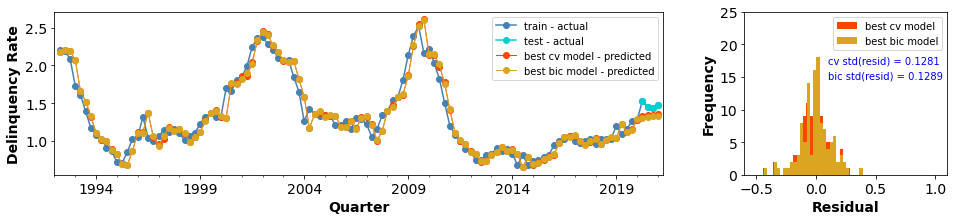

In [9]:
#Subsets 
#Train
is_train_idx02 = df_ln_full.index <= df_ln_train.index.max()
#Test
is_test_idx02 = df_ln_full.index >= df_ln_test.index.min()
#Train union Test
is_traintest_idx02 = is_train_idx02 | is_test_idx02
#Train union Test, ex first element
is_traintestex1_idx02 = is_traintest_idx02 & (df_ln_full.index > df_ln_full.loc[is_traintest_idx02,:].index.min())

#Get predicted values
#Best CV model
base_arima_model = pm.ARIMA(order=(4, 1, 1), with_intercept=False, scoring='mse', maxiter=20, suppress_warnings=True)
base_arima_model.fit(df_ln_full.loc[is_train_idx02,'delinq'])
y_base_pred_cv_best = base_arima_model.predict_in_sample()
y_base_frcst_cv_best = base_arima_model.predict(n_periods=4)
y_base_resid_cv_best = base_arima_model.resid()
#Best BIC model
base_arima_model = pm.ARIMA(order=(2, 1, 0), with_intercept=False, scoring='mse', maxiter=20, suppress_warnings=True)
base_arima_model.fit(df_ln_full.loc[is_train_idx02,'delinq'])
y_base_pred_bic_best = base_arima_model.predict_in_sample()
y_base_frcst_bic_best = base_arima_model.predict(n_periods=4)
y_base_resid_bic_best = base_arima_model.resid()

#Predictions to dataframe
df_base_pred_best = pd.DataFrame(np.exp(np.concatenate((y_base_pred_cv_best,y_base_frcst_cv_best),axis=0)))
df_base_pred_best = pd.concat([df_base_pred_best, pd.DataFrame(np.exp(np.concatenate((y_base_pred_bic_best,y_base_frcst_bic_best),axis=0)))], axis=1, join='inner')
df_base_pred_best.drop(labels=0, axis=0,inplace=True)
df_base_pred_best.columns = ['y_pred_cv','y_pred_bic']  
df_base_pred_best.index = df_full.loc[is_traintestex1_idx02,:].index
df_base_pred_best['y_resid_cv'] = df_full.loc[is_traintestex1_idx02,'delinq'] - df_base_pred_best['y_pred_cv']
df_base_pred_best['y_resid_bic'] = df_full.loc[is_traintestex1_idx02,'delinq'] - df_base_pred_best['y_pred_bic']
num_02 = np.abs(df_base_pred_best['y_pred_cv'] - df_full.loc[is_traintestex1_idx02,'delinq'])
den_02 = np.abs(df_full.loc[is_traintestex1_idx02,'delinq'])
df_base_pred_best['y_ape_cv'] = num_02/den_02
num_02 = np.abs(df_base_pred_best['y_pred_bic'] - df_full.loc[is_traintestex1_idx02,'delinq'])
den_02 = np.abs(df_full.loc[is_traintestex1_idx02,'delinq'])
df_base_pred_best['y_ape_bic'] = num_02/den_02

#Plot actual, predicted values for training, test data for best models
fig02, axes02 = plt.subplots(nrows=1,ncols=2,figsize=(16,3),gridspec_kw={'width_ratios': [3, 1]})
  
#line plot
#train: actual
df_full.loc[is_traintestex1_idx02,'delinq'].plot(ax=axes02[0],style="-o",linewidth=1.5,color='steelblue')
#test: actual
df_full.loc[is_test_idx02,'delinq'].plot(ax=axes02[0],style="-o",linewidth=1.5,color='darkturquoise')
#train: predicted, forecast - cv
df_base_pred_best['y_pred_cv'].plot(ax=axes02[0],style="-o",linewidth=1.0,color='orangered')
#train: predicted, forecast - bic
df_base_pred_best['y_pred_bic'].plot(ax=axes02[0],style="-o",linewidth=1.0,color='goldenrod')

#format
axes02[0].set_xlabel('Quarter', fontsize = 14.0, fontweight='bold')
axes02[0].tick_params(axis='x', labelsize=14)
axes02[0].set_ylabel('Delinquency Rate', fontsize = 14.0, fontweight='bold') 
axes02[0].tick_params(axis='y', labelsize=14)
axes02[0].set_xlim('1992Q1', '2021Q2')
axes02[0].legend(labels=['train - actual','test - actual','best cv model - predicted','best bic model - predicted'],fontsize=10.0)

#histogram plot
df_base_pred_best['y_resid_cv'].plot(ax=axes02[1],kind='hist',bins=30,color='orangered')
df_base_pred_best['y_resid_bic'].plot(ax=axes02[1],kind='hist',bins=30,color='goldenrod')
axes02[1].set_xlabel('Residual', fontsize=14.0, fontweight='bold')
axes02[1].tick_params(axis='x', labelsize=14)
axes02[1].set_ylabel('Frequency', fontsize=14.0, fontweight='bold') 
axes02[1].tick_params(axis='y', labelsize=14) 
axes02[1].legend(labels=['best cv model','best bic model'],fontsize=10.0)
axes02[1].set_xlim(-0.60,+1.1)
axes02[1].set_ylim(0,25)

#annotate
stdres_cv02 = np.std(df_base_pred_best['y_resid_cv'])
x_stdres_cv02 = 0.10
y_stdres_cv02 = 17
stdres_text_cv02 = 'cv std(resid) = ' + '{:.4f}'.format(stdres_cv02)
stdres_bic02 = np.std(df_base_pred_best['y_resid_bic'])
x_stdres_bic02 = 0.10
y_stdres_bic02 = 14.8
stdres_text_bic02 = 'bic std(resid) = ' + '{:.4f}'.format(stdres_bic02)
axes02[1].text(x_stdres_cv02, y_stdres_cv02, stdres_text_cv02, fontsize=10.0, color='blue')
axes02[1].text(x_stdres_bic02, y_stdres_bic02, stdres_text_bic02, fontsize=10.0, color='blue')

### <b><font color='blue'> Interpretation: Baseline Models </font></b>
The 2-parameter model ARIMA(2,1,0), which happens to have the best BIC value, fits the data essentially identically 
to the best CV score model, model ARIMA(4,1,1), which has 5 parameters. In fact, the standard deviations of the residuals for the two models are identical to 3 decimal places.

## 3 ARIMA(0,1,0)  with Features (Predictors) Models
### <b>3.1 Fit ARIMA(0,1,0) Model with Exogenous Variables</b>

In Section 2, I evaluated alternative ARIMA(p,1,q) models without exogenous variables using cross validation. In this section, using the same cross validation approach, I add exgoneous variables (features) to a a null ARIMA(0,1,0) model to identify features (predictors) that can explain lease delinquency rate. The goal is to identify features that can explain and predict the time series structure of lease delinquency rate.

<ol type="1">
   <li>The data and cross validation methodology are the same as in Section 2.</li>
   <li>As listed in the introduction, there are seven time series features included for analysis. If lags up to length 10 are considered, and only linear predictor variables are allowed, then there are 10 potential feature variables available for each of the seven time series, for a total of 70 predictor variables. Clearly, the full parameter space of 70 linear predictor-lag combinations is dimensionally high.</li>
   <li>Given the high dimensionality of the feature space, it is not feasible to evaluate all combinations of all 70 predictor-lag variables. Hence, following [HA 2021, section 7.5], I adopt a forward stepwise regression approach with 8 iterations.  Eight iterations allows each predictor to be included at least 1 time.  I consider lags up to length 10, which is consistent with the observed partial autocorrelations up to lag 8 in the lease deliquency rate and up to lag 10 in the lease receivable feature.</li>
    <li>In each iteration of the stepwise procedure, I identify the best fit predictor-lag variable by cross validation.  The best predictor-lag at each iteration is then retained in the model in future iterations.  Hence, after iteration i, the best model contains the best i linear features (predictor-lag combinations) added in sequence.</li>
    <li>Note that the length of a time series is reduced by the lag, so a lag j time series looses the first j observations in the series.  Because I am considering lags up to length 10, all data sets are trimmed to remove the first 10 observations.  That is, the length of the data are constrained by the largest lag value under consideration, which is lag=10 in this analysis.</li>
   <li>As in Section 2, models are scored using average mean squared error (MSE), with the average (mean) taken over folds.  AIC and BIC model selection criteria are also calculated, in these cases using the full training data series for each parameter set.</li>
</ol>

In [11]:
#score results [iteration, predictor, lag, score_mean, score_std]
exog_best_set = set()
df_exog_exmaxlag_best = pd.DataFrame()
exog_arima_cv_res = []

#predictor set, lag set
subset_pred_meta02 = [s for s in subset_meta if s[1]=='predictor']
lag_set02 = [1,2,3,4,5,6,7,8,9,10]      #[1,2,3,4,5,6]

#train subset, handle max lag in increments of 4 rounded up
lag_max_02 = np.max(lag_set02)
lag_max4inc_02 = 4*int(np.ceil(lag_max_02/4))
is_train_idx_lag02 = df_ln_train.index >= df_ln_train.index[0 + lag_max4inc_02]

#cross-validation folds, set initial set to 65 - (increments of 4 rounded up)
initial_cvseries02 = 65 - lag_max4inc_02
cvset_exog_arima_model = pm.model_selection.RollingForecastCV(h=4, step=4, initial=initial_cvseries02)

#loop predictors, loop lags, fit by cross validation, 
    #...include and save best ith predictor for i = 1, 2, ..., k predictors
k02 = 8
it02 = 0
lag_max02 = 0
lag_max_try02 = 0
initial_cvseries02 = 65
df_exog_best_try02 = pd.DataFrame()
df_exog_best_try_res02 = pd.DataFrame()
for it02 in range(1,k02+1):
    #status
    print('iteration:',it02)  
    #re-set counter, best score at current iteration
    i_try02 = 0
    param_best_try02 = set()
    scor_mean_best02 = 0.0
    
    for p_idx02, p_meta02 in enumerate(subset_pred_meta02):
        #X predictor name
        X_col_nm02 = p_meta02[0]
        for lag02 in lag_set02:
        
            #check if current parameters are already in best set, if yes then skip cv
            param_try02 = X_col_nm02 + '_' + str(lag02)
            if param_try02 in exog_best_set:
                print('in best set: break here')
                continue
        
            #counter in current iteration
            i_try02 = i_try02 + 1 
        
            #get X data for lag, inner join
            #OLD: X_exog02 = df_ln_train[[X_col_nm02]].shift(periods=lag02,axis=0).dropna()
            df_exog_try02 = df_ln_train[[X_col_nm02]].shift(periods=lag02,axis=0).loc[is_train_idx_lag02,:]
            if len(df_exog_exmaxlag_best) > 0:
                df_exog_best_try02 = pd.concat([df_exog_exmaxlag_best, df_exog_try02], axis=1, join='inner')
            else:
                df_exog_best_try02 = df_exog_try02
            
            #get Y data 
            Y_resp02 = df_ln_train.loc[is_train_idx_lag02,'delinq']
            
            #arima model (0,1,0), with_intercept = False
            exog_arima_model = pm.ARIMA(order=(0, 1, 0), with_intercept=False, scoring='mse', maxiter=20, suppress_warnings=True)
            cv_scor_exog_arima_model = pm.model_selection.cross_validate(exog_arima_model, Y_resp02, X=df_exog_best_try02, scoring='mean_squared_error', cv=cvset_exog_arima_model, verbose=0)
            #fit full training data
            exog_arima_model.fit(Y_resp02, X=df_exog_best_try02)
            
            #results - current iteration: store, if best at current iteration
            scor_mean02 = np.mean(cv_scor_exog_arima_model['test_score'])
            scor_std02 = np.std(cv_scor_exog_arima_model['test_score'])
            aic02 = exog_arima_model.aic()
            bic02 = exog_arima_model.bic()
            if i_try02 == 1:
                param_best_try02.add(param_try02)
                scor_mean_best02 = scor_mean02 
                exog_arima_cv_try_res02 = [it02, X_col_nm02, lag02, scor_mean02, scor_std02, aic02, bic02]
                df_exog_best_try_res02 = df_exog_best_try02
            else:
                if scor_mean02 < scor_mean_best02:
                    param_best_try02 = {param_try02}
                    scor_mean_best02 = scor_mean02
                    exog_arima_cv_try_res02 = [it02, X_col_nm02, lag02, scor_mean02, scor_std02, aic02, bic02]
                    df_exog_best_try_res02 = df_exog_best_try02
                elif scor_mean02 == scor_mean_best02:
                    param_best_try02.add(param_try02)
                    exog_arima_cv_try_res02.append([it02, X_col_nm02, lag02, scor_mean02, scor_std02, aic02, bic02])
                    df_exog_best_try_res02 = pd.concat([df_exog_best_try_res02, df_exog_try02], axis=1, join='inner')
            
            print('iteration:',it02,X_col_nm02,lag02,len(df_exog_best_try02),len(Y_resp02),'{:.4f}'.format(scor_mean02),'{:.4f}'.format(scor_mean_best02),param_best_try02,exog_best_set) 
 

    #save data on best exogenous variables [iteration, predictor, lag, score_mean, score_std]
    if len(exog_best_set) == 0:
        exog_best_set = param_best_try02
    else:
        exog_best_set = exog_best_set.union(param_best_try02)
    exog_arima_cv_res.append(exog_arima_cv_try_res02)
    df_exog_exmaxlag_best = df_exog_best_try_res02


#save results in dataframe
df_exog_arima_cv_res = pd.DataFrame(exog_arima_cv_res) 
df_exog_arima_cv_res.columns = ['iteration', 'predictor', 'lag', 'mse_mean', 'mse_std', 'aic', 'bic']   

print('all done CV with exog')

iteration: 1
iteration: 1 ls_rcvbl 1 101 101 0.0303 0.0303 {'ls_rcvbl_1'} set()
iteration: 1 ls_rcvbl 2 101 101 0.0301 0.0301 {'ls_rcvbl_2'} set()
iteration: 1 ls_rcvbl 3 101 101 0.0290 0.0290 {'ls_rcvbl_3'} set()
iteration: 1 ls_rcvbl 4 101 101 0.0283 0.0283 {'ls_rcvbl_4'} set()
iteration: 1 ls_rcvbl 5 101 101 0.0287 0.0283 {'ls_rcvbl_4'} set()
iteration: 1 ls_rcvbl 6 101 101 0.0281 0.0281 {'ls_rcvbl_6'} set()
iteration: 1 ls_rcvbl 7 101 101 0.0278 0.0278 {'ls_rcvbl_7'} set()
iteration: 1 ls_rcvbl 8 101 101 0.0279 0.0278 {'ls_rcvbl_7'} set()
iteration: 1 ls_rcvbl 9 101 101 0.0290 0.0278 {'ls_rcvbl_7'} set()
iteration: 1 ls_rcvbl 10 101 101 0.0282 0.0278 {'ls_rcvbl_7'} set()
iteration: 1 pmi_man 1 101 101 0.0339 0.0278 {'ls_rcvbl_7'} set()
iteration: 1 pmi_man 2 101 101 0.0308 0.0278 {'ls_rcvbl_7'} set()
iteration: 1 pmi_man 3 101 101 0.0264 0.0264 {'pmi_man_3'} set()
iteration: 1 pmi_man 4 101 101 0.0331 0.0264 {'pmi_man_3'} set()
iteration: 1 pmi_man 5 101 101 0.0312 0.0264 {'pmi_man

iteration: 2 stdtght_ci_smll_netpct 1 101 101 0.0230 0.0204 {'cons_sent_2'} {'tot_bus_inv_8'}
iteration: 2 stdtght_ci_smll_netpct 2 101 101 0.0234 0.0204 {'cons_sent_2'} {'tot_bus_inv_8'}
iteration: 2 stdtght_ci_smll_netpct 3 101 101 0.0252 0.0204 {'cons_sent_2'} {'tot_bus_inv_8'}
iteration: 2 stdtght_ci_smll_netpct 4 101 101 0.0226 0.0204 {'cons_sent_2'} {'tot_bus_inv_8'}
iteration: 2 stdtght_ci_smll_netpct 5 101 101 0.0243 0.0204 {'cons_sent_2'} {'tot_bus_inv_8'}
iteration: 2 stdtght_ci_smll_netpct 6 101 101 0.0241 0.0204 {'cons_sent_2'} {'tot_bus_inv_8'}
iteration: 2 stdtght_ci_smll_netpct 7 101 101 0.0251 0.0204 {'cons_sent_2'} {'tot_bus_inv_8'}
iteration: 2 stdtght_ci_smll_netpct 8 101 101 0.0238 0.0204 {'cons_sent_2'} {'tot_bus_inv_8'}
iteration: 2 stdtght_ci_smll_netpct 9 101 101 0.0243 0.0204 {'cons_sent_2'} {'tot_bus_inv_8'}
iteration: 2 stdtght_ci_smll_netpct 10 101 101 0.0243 0.0204 {'cons_sent_2'} {'tot_bus_inv_8'}
iteration: 2 tot_bus_inv 1 101 101 0.0214 0.0204 {'cons_sen

iteration: 3 ret_sales 1 101 101 0.0201 0.0163 {'pmi_man_1'} {'ret_sales_2', 'tot_bus_inv_8'}
in best set: break here
iteration: 3 ret_sales 3 101 101 0.0194 0.0163 {'pmi_man_1'} {'ret_sales_2', 'tot_bus_inv_8'}
iteration: 3 ret_sales 4 101 101 0.0216 0.0163 {'pmi_man_1'} {'ret_sales_2', 'tot_bus_inv_8'}
iteration: 3 ret_sales 5 101 101 0.0201 0.0163 {'pmi_man_1'} {'ret_sales_2', 'tot_bus_inv_8'}
iteration: 3 ret_sales 6 101 101 0.0179 0.0163 {'pmi_man_1'} {'ret_sales_2', 'tot_bus_inv_8'}
iteration: 3 ret_sales 7 101 101 0.0182 0.0163 {'pmi_man_1'} {'ret_sales_2', 'tot_bus_inv_8'}
iteration: 3 ret_sales 8 101 101 0.0166 0.0163 {'pmi_man_1'} {'ret_sales_2', 'tot_bus_inv_8'}
iteration: 3 ret_sales 9 101 101 0.0199 0.0163 {'pmi_man_1'} {'ret_sales_2', 'tot_bus_inv_8'}
iteration: 3 ret_sales 10 101 101 0.0204 0.0163 {'pmi_man_1'} {'ret_sales_2', 'tot_bus_inv_8'}
iteration: 4
iteration: 4 ls_rcvbl 1 101 101 0.0155 0.0155 {'ls_rcvbl_1'} {'pmi_man_1', 'ret_sales_2', 'tot_bus_inv_8'}
iteration

iteration: 4 ret_sales 10 101 101 0.0166 0.0129 {'ls_rcvbl_8'} {'pmi_man_1', 'ret_sales_2', 'tot_bus_inv_8'}
iteration: 5
iteration: 5 ls_rcvbl 1 101 101 0.0136 0.0136 {'ls_rcvbl_1'} {'pmi_man_1', 'ret_sales_2', 'tot_bus_inv_8', 'ls_rcvbl_8'}
iteration: 5 ls_rcvbl 2 101 101 0.0133 0.0133 {'ls_rcvbl_2'} {'pmi_man_1', 'ret_sales_2', 'tot_bus_inv_8', 'ls_rcvbl_8'}
iteration: 5 ls_rcvbl 3 101 101 0.0129 0.0129 {'ls_rcvbl_3'} {'pmi_man_1', 'ret_sales_2', 'tot_bus_inv_8', 'ls_rcvbl_8'}
iteration: 5 ls_rcvbl 4 101 101 0.0137 0.0129 {'ls_rcvbl_3'} {'pmi_man_1', 'ret_sales_2', 'tot_bus_inv_8', 'ls_rcvbl_8'}
iteration: 5 ls_rcvbl 5 101 101 0.0141 0.0129 {'ls_rcvbl_3'} {'pmi_man_1', 'ret_sales_2', 'tot_bus_inv_8', 'ls_rcvbl_8'}
iteration: 5 ls_rcvbl 6 101 101 0.0130 0.0129 {'ls_rcvbl_3'} {'pmi_man_1', 'ret_sales_2', 'tot_bus_inv_8', 'ls_rcvbl_8'}
iteration: 5 ls_rcvbl 7 101 101 0.0129 0.0129 {'ls_rcvbl_3'} {'pmi_man_1', 'ret_sales_2', 'tot_bus_inv_8', 'ls_rcvbl_8'}
in best set: break here
iterati

iteration: 5 ret_sales 9 101 101 0.0134 0.0113 {'close_price_3'} {'pmi_man_1', 'ret_sales_2', 'tot_bus_inv_8', 'ls_rcvbl_8'}
iteration: 5 ret_sales 10 101 101 0.0134 0.0113 {'close_price_3'} {'pmi_man_1', 'ret_sales_2', 'tot_bus_inv_8', 'ls_rcvbl_8'}
iteration: 6
iteration: 6 ls_rcvbl 1 101 101 0.0112 0.0112 {'ls_rcvbl_1'} {'close_price_3', 'ret_sales_2', 'pmi_man_1', 'tot_bus_inv_8', 'ls_rcvbl_8'}
iteration: 6 ls_rcvbl 2 101 101 0.0108 0.0108 {'ls_rcvbl_2'} {'close_price_3', 'ret_sales_2', 'pmi_man_1', 'tot_bus_inv_8', 'ls_rcvbl_8'}
iteration: 6 ls_rcvbl 3 101 101 0.0116 0.0108 {'ls_rcvbl_2'} {'close_price_3', 'ret_sales_2', 'pmi_man_1', 'tot_bus_inv_8', 'ls_rcvbl_8'}
iteration: 6 ls_rcvbl 4 101 101 0.0112 0.0108 {'ls_rcvbl_2'} {'close_price_3', 'ret_sales_2', 'pmi_man_1', 'tot_bus_inv_8', 'ls_rcvbl_8'}
iteration: 6 ls_rcvbl 5 101 101 0.0122 0.0108 {'ls_rcvbl_2'} {'close_price_3', 'ret_sales_2', 'pmi_man_1', 'tot_bus_inv_8', 'ls_rcvbl_8'}
iteration: 6 ls_rcvbl 6 101 101 0.0115 0.0108 

iteration: 6 ret_sales 1 101 101 0.0130 0.0102 {'cons_sent_1'} {'close_price_3', 'ret_sales_2', 'pmi_man_1', 'tot_bus_inv_8', 'ls_rcvbl_8'}
in best set: break here
iteration: 6 ret_sales 3 101 101 0.0113 0.0102 {'cons_sent_1'} {'close_price_3', 'ret_sales_2', 'pmi_man_1', 'tot_bus_inv_8', 'ls_rcvbl_8'}
iteration: 6 ret_sales 4 101 101 0.0127 0.0102 {'cons_sent_1'} {'close_price_3', 'ret_sales_2', 'pmi_man_1', 'tot_bus_inv_8', 'ls_rcvbl_8'}
iteration: 6 ret_sales 5 101 101 0.0114 0.0102 {'cons_sent_1'} {'close_price_3', 'ret_sales_2', 'pmi_man_1', 'tot_bus_inv_8', 'ls_rcvbl_8'}
iteration: 6 ret_sales 6 101 101 0.0112 0.0102 {'cons_sent_1'} {'close_price_3', 'ret_sales_2', 'pmi_man_1', 'tot_bus_inv_8', 'ls_rcvbl_8'}
iteration: 6 ret_sales 7 101 101 0.0106 0.0102 {'cons_sent_1'} {'close_price_3', 'ret_sales_2', 'pmi_man_1', 'tot_bus_inv_8', 'ls_rcvbl_8'}
iteration: 6 ret_sales 8 101 101 0.0106 0.0102 {'cons_sent_1'} {'close_price_3', 'ret_sales_2', 'pmi_man_1', 'tot_bus_inv_8', 'ls_rcvbl_

iteration: 7 stdtght_ci_smll_netpct 9 101 101 0.0099 0.0092 {'cons_sent_8'} {'close_price_3', 'ret_sales_2', 'cons_sent_1', 'pmi_man_1', 'tot_bus_inv_8', 'ls_rcvbl_8'}
iteration: 7 stdtght_ci_smll_netpct 10 101 101 0.0101 0.0092 {'cons_sent_8'} {'close_price_3', 'ret_sales_2', 'cons_sent_1', 'pmi_man_1', 'tot_bus_inv_8', 'ls_rcvbl_8'}
iteration: 7 tot_bus_inv 1 101 101 0.0107 0.0092 {'cons_sent_8'} {'close_price_3', 'ret_sales_2', 'cons_sent_1', 'pmi_man_1', 'tot_bus_inv_8', 'ls_rcvbl_8'}
iteration: 7 tot_bus_inv 2 101 101 0.0131 0.0092 {'cons_sent_8'} {'close_price_3', 'ret_sales_2', 'cons_sent_1', 'pmi_man_1', 'tot_bus_inv_8', 'ls_rcvbl_8'}
iteration: 7 tot_bus_inv 3 101 101 0.0111 0.0092 {'cons_sent_8'} {'close_price_3', 'ret_sales_2', 'cons_sent_1', 'pmi_man_1', 'tot_bus_inv_8', 'ls_rcvbl_8'}
iteration: 7 tot_bus_inv 4 101 101 0.0103 0.0092 {'cons_sent_8'} {'close_price_3', 'ret_sales_2', 'cons_sent_1', 'pmi_man_1', 'tot_bus_inv_8', 'ls_rcvbl_8'}
iteration: 7 tot_bus_inv 5 101 101 

iteration: 8 close_price 5 101 101 0.0091 0.0087 {'ls_rcvbl_7'} {'close_price_3', 'ret_sales_2', 'cons_sent_1', 'pmi_man_1', 'cons_sent_8', 'tot_bus_inv_8', 'ls_rcvbl_8'}
iteration: 8 close_price 6 101 101 0.0093 0.0087 {'ls_rcvbl_7'} {'close_price_3', 'ret_sales_2', 'cons_sent_1', 'pmi_man_1', 'cons_sent_8', 'tot_bus_inv_8', 'ls_rcvbl_8'}
iteration: 8 close_price 7 101 101 0.0094 0.0087 {'ls_rcvbl_7'} {'close_price_3', 'ret_sales_2', 'cons_sent_1', 'pmi_man_1', 'cons_sent_8', 'tot_bus_inv_8', 'ls_rcvbl_8'}
iteration: 8 close_price 8 101 101 0.0094 0.0087 {'ls_rcvbl_7'} {'close_price_3', 'ret_sales_2', 'cons_sent_1', 'pmi_man_1', 'cons_sent_8', 'tot_bus_inv_8', 'ls_rcvbl_8'}
iteration: 8 close_price 9 101 101 0.0093 0.0087 {'ls_rcvbl_7'} {'close_price_3', 'ret_sales_2', 'cons_sent_1', 'pmi_man_1', 'cons_sent_8', 'tot_bus_inv_8', 'ls_rcvbl_8'}
iteration: 8 close_price 10 101 101 0.0090 0.0087 {'ls_rcvbl_7'} {'close_price_3', 'ret_sales_2', 'cons_sent_1', 'pmi_man_1', 'cons_sent_8', 'tot

### <b>3.2 Exogenous Models Cross Validation: Table Summary Sorted by Best CV Score </b><br>
<li>As explained above, column 'Iteration' is a step of the forward stepwise regression process. Hence, each row is the cross validation result of the (predictor, lag) exogenous variable added to the ARIMA(0,1,0) model.  Iteration i includes the best-fit variable (predictor, lag) for the ith iteration plus the best-fit set of variables { (predictor, lag) } for all prior iterations, because each step adds an exogenous variable to the model in a stepwise manner. </li>
<li>Column 'mse_mean' is the mean MSE, with the mean taken over folds.</li>
<li>AIC, BIC scores for each model are shown as well, calculated on the full training data set.</li>
<li>Rows are sorted by column 'Iteration' in ascending order.</li>

In [12]:
#rank by mse, aic, bic
df_exog_arima_cv_res.loc[:,'mse_mean_rk'] = df_exog_arima_cv_res.loc[:,'mse_mean'].rank(axis=0,ascending=True)
df_exog_arima_cv_res.loc[:,'aic_rk'] = df_exog_arima_cv_res.loc[:,'aic'].rank(axis=0,ascending=True)
df_exog_arima_cv_res.loc[:,'bic_rk'] = df_exog_arima_cv_res.loc[:,'bic'].rank(axis=0,ascending=True)

#print top 10
df_exog_arima_cv_res.head(10)

,iteration,predictor,lag,mse_mean,mse_std,aic,bic,mse_mean_rk,aic_rk,bic_rk
0,1,tot_bus_inv,8,0.024240,0.027830,-186.552994,-181.342654,8.0,8.0,5.0
1,2,ret_sales,2,0.019464,0.019439,-190.435323,-182.619812,7.0,7.0,4.0
2,3,pmi_man,1,0.016323,0.017200,-196.777865,-186.357184,6.0,5.0,1.0
3,4,ls_rcvbl,8,0.012902,0.012471,-198.155788,-185.129937,5.0,2.0,2.0
4,5,close_price,3,0.011335,0.009302,-198.736222,-183.105200,4.0,1.0,3.0
5,6,cons_sent,1,0.010242,0.009102,-197.146451,-178.910259,3.0,3.0,6.0
6,7,cons_sent,8,0.009242,0.006591,-195.297431,-174.456070,2.0,6.0,7.0
7,8,ls_rcvbl,7,0.008743,0.005907,-196.881059,-173.434527,1.0,4.0,8.0


### <b>3.3 Exogenous Models Cross Validation: Plot Mean MSE vs Number of Exogenous Variables</b><br>
   <li>Plot of mean MSE ('mse_mean') versus number of exogenous variables in the model (captured in column 'Iteration').</li>

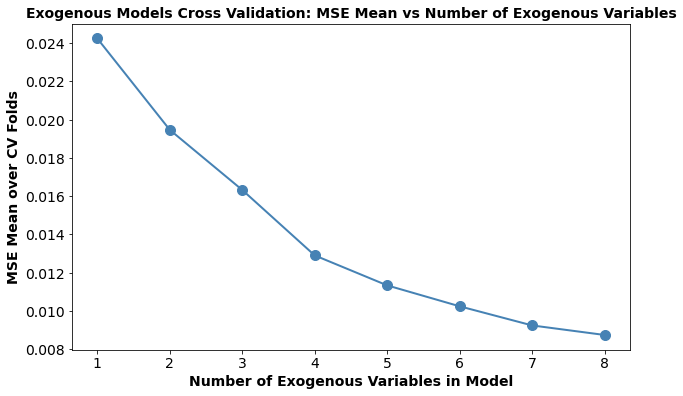

In [13]:
#Plot model selection scores (mse_mean vs iteration), annotate (p,q)
fig03, axes03 = plt.subplots(nrows=1,ncols=1,figsize=(10,6))

#line plot
df_exog_arima_cv_res.plot(ax=axes03,x='iteration',y='mse_mean',style="-o",linewidth=2.0,markersize=10.0,color='steelblue')
    
axes03.set_title('Exogenous Models Cross Validation: MSE Mean vs Number of Exogenous Variables', fontsize = 14.0, fontweight='bold')
axes03.set_xlabel('Number of Exogenous Variables in Model', fontsize = 14.0, fontweight='bold')
axes03.tick_params(axis='x', labelsize=14)
axes03.set_ylabel('MSE Mean over CV Folds', fontsize = 14.0, fontweight='bold') 
axes03.tick_params(axis='y', labelsize=14)
axes03.get_legend().remove()

### <b><font color='blue'> Interpretation: Exogenous Models </font></b>
Model fit improves with the inclusion of each additional exogenous variable, but the marginal improvement in fit declines with each additional variable added to the model.  Inclusion of 4 predictors as exogenous variables captures most of the improvement in fit.  Hence, the 4-parameter model will be the focus of further evaluations.<br>

A summary table of the 4-parameter model is shown below. The included predictors, in order of importance, are { 'tot_bus_inv_8', 'ret_sales_2', 'pmi_man_1', 'ls_rcvbl_8'} (labels are of the form 'predictor_lag').  Interestingly, two predictors with lag=8 are in the best set, which matches the lag=8 partial autocorrelation that was observed for lease delinquency rate in the EDA notebook. Also, two of the best predictors have shorter lags of 1 and 2, which also aligns with the observed partial autocorrelation for lease delinquency rate. Finally, these same 4 predictors were also identified in the cross correlation analysis in the EDA notebook as potentially have a relationship with the response variable, lease deliquency rate. So, these results are consistent with the initial analysis in the EDA notebook.

### <b>3.4 Exogenous Models Cross Validation: Summary of the Best 4-Parameter Model by CV Score</b>

In [14]:
#get best exogenous time series by (predictor,lag)
idx_max02 = df_exog_arima_cv_res[df_exog_arima_cv_res['mse_mean_rk']==5.0].index[0]

colset02 = []
df_exog_best02 = pd.DataFrame()
for idx02 in range(idx_max02+1):
    #(predictor,lag)
    exog_nm02 = df_exog_arima_cv_res.loc[idx02,'predictor']
    lagn_02 = df_exog_arima_cv_res.loc[idx02,'lag']
    colset02.append(exog_nm02 + '_' + str(lagn_02))

    #get X data for lag, inner join
    df_X_exog02 = df_ln_train[[exog_nm02]].shift(periods=lagn_02,axis=0).dropna()
    
    if len(df_exog_best02) > 0:
        df_exog_best02 = pd.concat([df_exog_best02, df_X_exog02], axis=1, join='inner')
    else:
        df_exog_best02 = df_X_exog02


#column names
df_exog_best02.columns = colset02
#get Y data to match
is_idx02 = df_ln_train.index >= df_exog_best02.index[0]
df_y_exogtrn02 = df_ln_train.loc[is_idx02,'delinq']

#Fit model
exog_arima_model = pm.ARIMA(order=(0, 1, 0), with_intercept=False, scoring='mse', maxiter=30, suppress_warnings=True)
exog_arima_model.fit(df_y_exogtrn02, X=df_exog_best02)    
exog_arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  105
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 107.487
Date:                Thu, 15 Jul 2021   AIC                           -204.973
Time:                        00:44:13   BIC                           -191.751
Sample:                    03-31-1994   HQIC                          -199.617
                         - 03-31-2020                                         
Covariance Type:                  opg                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
tot_bus_inv_8     2.1801      0.717      3.041      0.002       0.775       3.585
ret_sales_2      -1.8703      0.562     -3.326      0.001      -2.973      -0.768
pmi_man_1        -0.3914      0.141     -2.777      0.005      -0.668      -0.115
ls_rcvbl_8        0.5468      0.302      1.811      0.070      -0.045       1.139
sigma2            0.0074      0.001      8.607      0.000       0.006       0.009
===================================================================================
Ljung-Box (L1) (Q):                   1.26   Jarque-Bera (JB):                 4.58
Prob(Q):                              0.26   Prob(JB):                         0.10
Heteroskedasticity (H):               0.60   Skew:                             0.03
Prob(H) (two-sided):                  0.14   Kurtosis:                         4.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### <b>3.5 Exogenous Models Cross Validation: Predicted Values of Best CV Model</b><br>

   <li>The goal in this section is to visualize the predictions of the best CV model versus the training and test data sets.</li>
   <li>Actual values of the lease delinquency rate time series are plotted for both training and test data sets.</li>
   <li>Predicted values for lease deliquency rate are plotted for both the training and test data sets.</li>
   <li>Histograms of model residuals (residuals from both training and test data sets) are plotted. Further assessment of model fit versus test data will be specifically considered in a later section.</li>
   <li>Lease delinquency rate values have been transformed back to the original time series units (model fitting was done on natural-log transformed, first-differenced data).</li>


Text(0.1, 15.5, 'cv std(resid) = 0.1118')

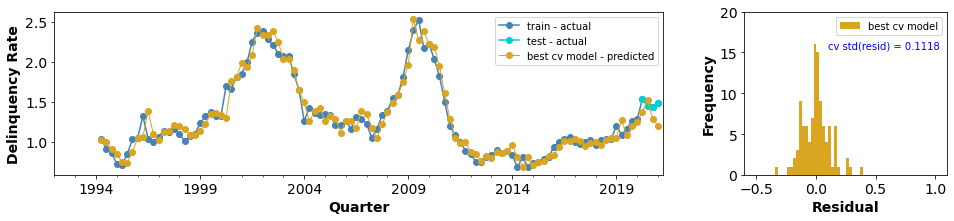

In [15]:
#Exogenous: time series by (predictor,lag), matching Y data for training
idx_max04 = df_exog_arima_cv_res[df_exog_arima_cv_res['mse_mean_rk']==5.0].index[0]
#df_ln_full, df_ln_train, df_ln_test

colset04 = []
df_exog_best = pd.DataFrame()
for idx04 in range(idx_max04+1):
    #(predictor,lag)
    exog_nm04 = df_exog_arima_cv_res.loc[idx04,'predictor']
    lagn_04 = df_exog_arima_cv_res.loc[idx04,'lag']
    colset04.append(exog_nm04 + '_' + str(lagn_04))

    #get X data for lag, inner join (need full data for predict, forecast)
    df_exog04 = df_ln_full[[exog_nm04]].shift(periods=lagn_04,axis=0)
    
    if len(df_exog_best) > 0:
        df_exog_best = pd.concat([df_exog_best, df_exog04], axis=1, join='inner')
    else:
        df_exog_best = df_exog04

#column names
df_exog_best.columns = colset04

#Subsets 
#Train, ex lag in exogenous
is_train_exlag_idx04 = (df_ln_full.index >= df_exog_best.dropna().index.min()) & (df_ln_full.index <= df_ln_train.index.max())
#Test
is_test_idx04 = df_ln_full.index >= df_ln_test.index.min()
#Train union Test, ex lag in exogenous
is_traintestexlag_idx04 = is_train_exlag_idx04 | is_test_idx04
#Train union Test, ex lag in exogenous, ex first element
is_traintestexlagex1_idx04 = is_traintestexlag_idx04 & (df_ln_full.index > df_ln_full.loc[is_traintestexlag_idx04,:].index.min())

#Best CV model
exog_arima_model = pm.ARIMA(order=(0, 1, 0), with_intercept=False, scoring='mse', maxiter=30, suppress_warnings=True)
exog_arima_model.fit(df_ln_full.loc[is_train_exlag_idx04,'delinq'], X=df_exog_best.loc[is_train_exlag_idx04,:])
y_exog_pred_cv_best = exog_arima_model.predict_in_sample(X=df_exog_best.loc[is_train_exlag_idx04,:])
y_exog_frcst_cv_best = exog_arima_model.predict(n_periods=4, X=df_exog_best.loc[is_test_idx04,:])
y_exog_resid_cv_best = exog_arima_model.resid()

#Predictions to dataframe
df_exog_pred_best = pd.DataFrame(np.exp(np.concatenate((y_exog_pred_cv_best,y_exog_frcst_cv_best),axis=0)))
df_exog_pred_best.drop(labels=0, axis=0,inplace=True)
df_exog_pred_best.columns = ['y_pred_cv']  
df_exog_pred_best.index = df_full.loc[is_traintestexlagex1_idx04,:].index
df_exog_pred_best['y_resid_cv'] = df_full.loc[is_traintestexlagex1_idx04,'delinq'] - df_exog_pred_best['y_pred_cv']
num_04 = np.abs(df_exog_pred_best['y_pred_cv'] - df_full.loc[is_traintestexlagex1_idx04,'delinq'])
den_04 = np.abs(df_full.loc[is_traintestexlagex1_idx04,'delinq'])
df_exog_pred_best['y_ape_cv'] = num_04/den_04

#Plot actual, predicted values for training, test data for best models
fig04, axes04 = plt.subplots(nrows=1,ncols=2,figsize=(16,3),gridspec_kw={'width_ratios': [3, 1]})
  
#line plot
#train: actual
df_full.loc[is_traintestexlagex1_idx04,'delinq'].plot(ax=axes04[0],style="-o",linewidth=1.5,color='steelblue')
#test: actual
df_full.loc[is_test_idx04,'delinq'].plot(ax=axes04[0],style="-o",linewidth=1.5,color='darkturquoise')
#train: predicted, forecast - cv
df_exog_pred_best['y_pred_cv'].plot(ax=axes04[0],style="-o",linewidth=1.0,color='goldenrod')

#format
axes04[0].set_xlabel('Quarter', fontsize = 14.0, fontweight='bold')
axes04[0].tick_params(axis='x', labelsize=14)
axes04[0].set_ylabel('Delinquency Rate', fontsize = 14.0, fontweight='bold') 
axes04[0].tick_params(axis='y', labelsize=14)
axes04[0].set_xlim('1992Q1', '2021Q2')
axes04[0].legend(labels=['train - actual','test - actual','best cv model - predicted'],fontsize=10.0)

#histogram plot
df_exog_pred_best['y_resid_cv'].plot(ax=axes04[1],kind='hist',bins=30,color='goldenrod')
axes04[1].set_xlabel('Residual', fontsize=14.0, fontweight='bold')
axes04[1].tick_params(axis='x', labelsize=14)
axes04[1].set_ylabel('Frequency', fontsize=14.0, fontweight='bold') 
axes04[1].tick_params(axis='y', labelsize=14) 
axes04[1].legend(labels=['best cv model'],fontsize=10.0)
axes04[1].set_xlim(-0.60,+1.1)
axes04[1].set_ylim(0,20)

#annotate
stdres_cv04 = np.std(df_exog_pred_best['y_resid_cv'])
x_stdres_cv04 = 0.10
y_stdres_cv04 = 15.5
stdres_text_cv04 = 'cv std(resid) = ' + '{:.4f}'.format(stdres_cv04)
axes04[1].text(x_stdres_cv04, y_stdres_cv04, stdres_text_cv04, fontsize=10.0, color='blue')

### <b><font color='blue'> Interpretation: Exogenous Models </font></b>
Qualitatively, the 4-parameter exogenous model [ARIMA(0,1,0) with 4 predictors with lags as exogenous variables { 'tot_bus_inv_8', 'ret_sales_2', 'pmi_man_1', 'ls_rcvbl_8'}], fits the data similarly to the best baseline ARIMA(p,1,q)=(2,1,0) model.  Quantitatvely, the 4-parameter exogenous model shows a slight improvement in fit as measured by the standard deviation of residuals (residuals over both training and test data sets). 

## 4 ARIMA(p,1,0)  with Best Features (Predictors) Models
### <b>4.1 Fit ARIMA(p,1,0) Model with Best Exogenous Variables</b>

In Sections 2 and 3, respectively, I evaluated alternative ARIMA(p,1,q) models without exogenous variables and alternative ARIMA(0,1,0) models with exogenous variables. In this section, using the same cross validation approach, I build on the results of the prior two sections and evaluate models of the form ARIMA(p,1,0) with exogenous variables. The goal is to identify the combination of autocorrelation parameter, p, and features (predictor-lag combinations) that can explain and predict the time series structure of lease delinquency rate.

<ol type="1">
   <li>The data and cross validation methodology are the same as in Sections 2 and 3.</li>
   <li>Leveraging the results from Sections 2 and 3, I consider autocorrelations p=0,1,2 and features that have predictor-lag combinations from the feature set {'tot_bus_inv_8', 'ret_sales_2', 'pmi_man_1', 'ls_rcvbl_8'}.</li>
   <li>Now that the parameter space is much reduced in terms of dimensionality (7 total predictor variables = 3 autocorrelations + 4 predictor-lag variables), I can evaluate the full set of all possible combinations of parameters in cross validation process.</li>
    <li>As in Section 2, the length of a time series is reduced by the lag, so a lag j time series looses the first j observations in the series.  In this section, I am considering lags up to length 8 (determined by the variables with the largest lags, {'tot_bus_inv_8', 'ls_rcvbl_8'}), all data sets are trimmed to remove the first 8 observations.</li>
    <li>As in Sections 2 and 3, models are scored using average mean squared error (MSE), with the average (mean) taken over folds.  AIC and BIC model selection criteria are also calculated, in these cases using the full training data series for each parameter set.</li>
</ol>


In [16]:
#parameter lists
p_lst03 = [0,1,2]
exog_best_lst03 = [list(v1) for i in range(4) for v1 in it.combinations(df_exog_best.columns, i+1)]

#cross-validation folds, set initial set to 65 + increments of 4 rounded up
cvset_full_arima_model = pm.model_selection.RollingForecastCV(h=4, step=4, initial=73)
#Train ex lag in exogenous
is_train_exlag_idx03 = (df_ln_full.index >= df_exog_best.dropna().index.min()) & (df_ln_full.index <= df_ln_train.index.max())
#predictor variables
df_exog_best03 = df_exog_best.loc[is_train_exlag_idx03,:]
#response variable
Y_resp03 = df_ln_full.loc[is_train_exlag_idx03,'delinq']

full_arima_cv_res = []
ct03 = 0
for p03 in p_lst03:
    for exog_lst03 in exog_best_lst03:
        #status
        ct03 = ct03 + 1
        
        #arima model (p,1,0), with_intercept = False, with exogenous
        full_arima_model = pm.ARIMA(order=(p03, 1, 0), with_intercept=False, scoring='mse', maxiter=30, suppress_warnings=True)
        cv_scor_full_arima_model = pm.model_selection.cross_validate(full_arima_model, Y_resp03, X=df_exog_best03[exog_lst03], scoring='mean_squared_error', cv=cvset_full_arima_model, verbose=0)
        #fit full training data
        full_arima_model.fit(Y_resp03, X=df_exog_best03[exog_lst03])
        
        #results
        scor_mean03 = np.mean(cv_scor_full_arima_model['test_score'])
        scor_std03 = np.std(cv_scor_full_arima_model['test_score'])
        aic03 = full_arima_model.aic()
        bic03 = full_arima_model.bic()
        full_arima_cv_res.append([ct03, p03, exog_lst03, scor_mean03, scor_std03, aic03, bic03])
             
        print('iteration:',ct03,p03,exog_lst03,len(df_exog_best03),len(Y_resp03),'{:.4f}'.format(scor_mean03)) 
        

#save results in dataframe
df_full_arima_cv_res = pd.DataFrame(full_arima_cv_res) 
df_full_arima_cv_res.columns = ['iteration', 'p', 'predictor_lag_set', 'mse_mean', 'mse_std', 'aic', 'bic']   

print('all done CV full arima with exog')

iteration: 1 0 ['tot_bus_inv_8'] 105 105 0.0154
iteration: 2 0 ['ret_sales_2'] 105 105 0.0118
iteration: 3 0 ['pmi_man_1'] 105 105 0.0098
iteration: 4 0 ['ls_rcvbl_8'] 105 105 0.0096
iteration: 5 0 ['tot_bus_inv_8', 'ret_sales_2'] 105 105 0.0131
iteration: 6 0 ['tot_bus_inv_8', 'pmi_man_1'] 105 105 0.0149
iteration: 7 0 ['tot_bus_inv_8', 'ls_rcvbl_8'] 105 105 0.0136
iteration: 8 0 ['ret_sales_2', 'pmi_man_1'] 105 105 0.0115
iteration: 9 0 ['ret_sales_2', 'ls_rcvbl_8'] 105 105 0.0106
iteration: 10 0 ['pmi_man_1', 'ls_rcvbl_8'] 105 105 0.0088
iteration: 11 0 ['tot_bus_inv_8', 'ret_sales_2', 'pmi_man_1'] 105 105 0.0126
iteration: 12 0 ['tot_bus_inv_8', 'ret_sales_2', 'ls_rcvbl_8'] 105 105 0.0102
iteration: 13 0 ['tot_bus_inv_8', 'pmi_man_1', 'ls_rcvbl_8'] 105 105 0.0131
iteration: 14 0 ['ret_sales_2', 'pmi_man_1', 'ls_rcvbl_8'] 105 105 0.0102
iteration: 15 0 ['tot_bus_inv_8', 'ret_sales_2', 'pmi_man_1', 'ls_rcvbl_8'] 105 105 0.0096
iteration: 16 1 ['tot_bus_inv_8'] 105 105 0.0132
iteratio

### <b>4.2 ARIMA with Exogenous Models Cross Validation: Table Summary Sorted by Best CV Score </b><br>

<li>Each row is the cross validation result of the best-fit (p,q), {predictor-lag} set parameter values indicated.</li>
<li>Column 'mse_mean' is the mean MSE, with the mean taken over folds.</li>
<li>AIC, BIC scores for each model are shown as well, calculated on the full training data set.</li>
<li>Rows are sorted by column 'mse_mean_rk' - the rank of 'mse_mean' over the best-fit parameter sets - in ascending order.</li>

In [17]:
#rank by mse, aic, bic
df_full_arima_cv_res.loc[:,'mse_mean_rk'] = df_full_arima_cv_res.loc[:,'mse_mean'].rank(axis=0,ascending=True)
df_full_arima_cv_res.loc[:,'aic_rk'] = df_full_arima_cv_res.loc[:,'aic'].rank(axis=0,ascending=True)
df_full_arima_cv_res.loc[:,'bic_rk'] = df_full_arima_cv_res.loc[:,'bic'].rank(axis=0,ascending=True)

#print top 15
df_full_arima_cv_res.sort_values('mse_mean_rk').head(15)

,iteration,p,predictor_lag_set,mse_mean,mse_std,aic,bic,mse_mean_rk,aic_rk,bic_rk
24,25,1,"[pmi_man_1, ls_rcvbl_8]",0.008017,0.004835,-185.126369,-174.548806,1.0,37.0,39.0
39,40,2,"[pmi_man_1, ls_rcvbl_8]",0.008304,0.006085,-185.650560,-172.428605,2.0,36.0,45.0
18,19,1,[ls_rcvbl_8],0.008578,0.007359,-182.485967,-174.552795,3.0,43.0,38.0
17,18,1,[pmi_man_1],0.008634,0.004825,-183.929225,-175.996052,4.0,40.0,32.0
9,10,0,"[pmi_man_1, ls_rcvbl_8]",0.008796,0.005944,-186.365057,-178.431885,5.0,34.0,26.0
32,33,2,[pmi_man_1],0.008808,0.006961,-185.669551,-175.091987,6.0,35.0,36.0
33,34,2,[ls_rcvbl_8],0.009286,0.008720,-183.886154,-173.308591,7.0,41.0,44.0
43,44,2,"[ret_sales_2, pmi_man_1, ls_rcvbl_8]",0.009429,0.005735,-190.707233,-174.840888,8.0,21.0,37.0
3,4,0,[ls_rcvbl_8],0.009558,0.008584,-183.393329,-178.104547,9.0,42.0,27.0
14,15,0,"[tot_bus_inv_8, ret_sales_2, pmi_man_1, ls_rcv...",0.009631,0.006071,-204.973374,-191.751420,10.0,1.0,2.0


### <b>4.3 ARIMA with Exogenous Models Cross Validation: Plot Mean MSE vs Rank Mean MSE</b><br>
<li>Plot of mean MSE ('mse_mean') versus rank of mean MSE ('mse_mean_rk'), as defined above.</li>

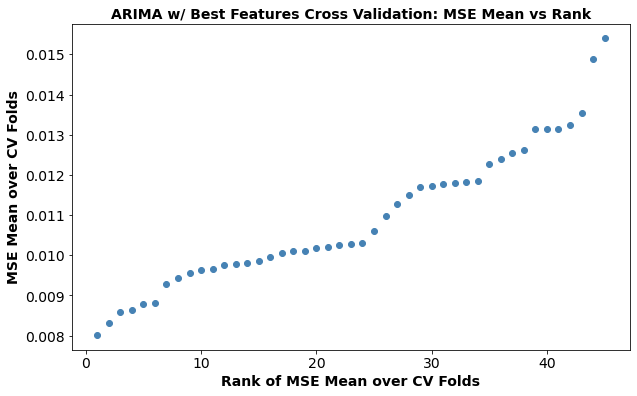

In [18]:
#Plot model selection scores (mse_mean vs rank)
fig05, axes05 = plt.subplots(nrows=1,ncols=1,figsize=(10,6))

#line plot
df_full_arima_cv_res.plot(ax=axes05,x='mse_mean_rk',y='mse_mean',style="o",markersize=6.0,color='steelblue')
    
axes05.set_title('ARIMA w/ Best Features Cross Validation: MSE Mean vs Rank', fontsize = 14.0, fontweight='bold')
axes05.set_xlabel('Rank of MSE Mean over CV Folds', fontsize = 14.0, fontweight='bold')
axes05.tick_params(axis='x', labelsize=14)
axes05.set_ylabel('MSE Mean over CV Folds', fontsize = 14.0, fontweight='bold') 
axes05.tick_params(axis='y', labelsize=14)
axes05.get_legend().remove()

### <b><font color='blue'> Interpretation: ARIMA with Exogenous Models </font></b>
The mean MSE (CV score) over folds declines steadily over the set of models ordered by mean MSE.  The best-fit model is ARIMA(1,1,0) with exogensous variables {'pmi_man_1', 'ls_rcvbl_8'}. As discussed in Section 2, the autocorrelation of p=1 and the best predictor-lag combinations are consistent with the results from the EDA notebook (partial autocorrelation, cross-correlation).

### <b>4.4 ARIMA with Exogenous Models Cross Validation: Summary of Best Model by CV Score</b>

In [19]:
#get best ARIMA with exogenous time series by ( p, { (predictor,lag) } )
idx_best03 = df_full_arima_cv_res[df_full_arima_cv_res['mse_mean_rk']==1.0].index[0]
p_best03 = df_full_arima_cv_res.loc[idx_best03,'p']
exog_bestset_03 = df_full_arima_cv_res.loc[idx_best03,'predictor_lag_set']

#X data
is_train_exlag_idx03 = (df_ln_full.index >= df_exog_best.dropna().index.min()) & (df_ln_full.index <= df_ln_train.index.max())
df_exog_best03 = df_exog_best.loc[is_train_exlag_idx03,exog_bestset_03]
#get Y data to match
df_y_exogtrn03 = df_ln_full.loc[is_train_exlag_idx03,'delinq']

#Fit model
full_arima_model = pm.ARIMA(order=(p_best03, 1, 0), with_intercept=False, scoring='mse', maxiter=30, suppress_warnings=True)
full_arima_model.fit(df_y_exogtrn03, X=df_exog_best03)    
full_arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  105
Model:               SARIMAX(1, 1, 0)   Log Likelihood                  96.563
Date:                Thu, 15 Jul 2021   AIC                           -185.126
Time:                        00:48:33   BIC                           -174.549
Sample:                    03-31-1994   HQIC                          -180.841
                         - 03-31-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
pmi_man_1     -0.3232      0.151     -2.142      0.032      -0.619      -0.027
ls_rcvbl_8     0.5428      0.314      1.727      0.084      -0.073       1.159
ar.L1          0.0860      0.086      0.995      0.320      -0.083       0.255
sigma2         0.0091      0.001      7.175      0.000       0.007       0.012
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 0.24
Prob(Q):                              0.88   Prob(JB):                         0.89
Heteroskedasticity (H):               0.69   Skew:                            -0.08
Prob(H) (two-sided):                  0.27   Kurtosis:                         3.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### <b>4.5 ARIMA with Exogenous Models Cross Validation: Predicted Values of Best CV Model</b><br>
   
   <li>The goal in this section is to visualize the predictions of the best CV model versus the training and test data sets.</li>
   <li>Actual values of the lease delinquency rate time series are plotted for both training and test data sets.</li>
   <li>Predicted values for lease deliquency rate are plotted for both the training and test data sets.</li>
   <li>Histograms of model residuals (residuals from both training and test data sets) are plotted. Further assessment of model fit versus test data will be specifically considered in a later section.</li>
   <li>Lease delinquency rate values have been transformed back to the original time series units (model fitting was done on natural-log transformed, first-differenced data).</li>



Text(0.1, 15.5, 'cv std(resid) = 0.1313')

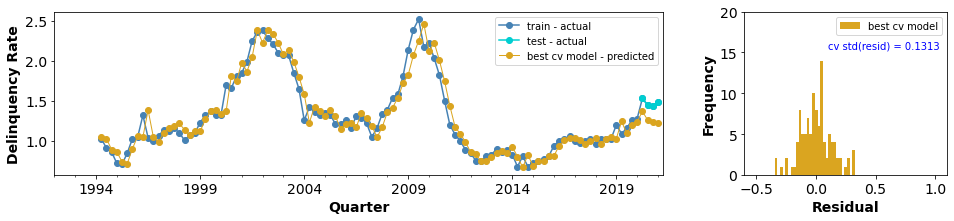

In [20]:
#ARIMA with Exogenous: time series by ( p, { (predictor,lag) } )
idx_best05 = df_full_arima_cv_res[df_full_arima_cv_res['mse_mean_rk']==1.0].index[0]
p_best05 = df_full_arima_cv_res.loc[idx_best05,'p']
exog_bestset_05 = df_full_arima_cv_res.loc[idx_best05,'predictor_lag_set']

#Subsets 
#Train, ex lag in exogenous
is_train_exlag_idx05 = (df_ln_full.index >= df_exog_best.dropna().index.min()) & (df_ln_full.index <= df_ln_train.index.max())
#Test
is_test_idx05 = df_ln_full.index >= df_ln_test.index.min()
#Train union Test, ex lag in exogenous
is_traintestexlag_idx05 = is_train_exlag_idx05 | is_test_idx05
#Train union Test, ex lag in exogenous, ex first element
is_traintestexlagex1_idx05 = is_traintestexlag_idx05 & (df_ln_full.index > df_ln_full.loc[is_traintestexlag_idx05,:].index.min())

#Best CV model
full_arima_model = pm.ARIMA(order=(p_best05, 1, 0), with_intercept=False, scoring='mse', maxiter=30, suppress_warnings=True)
full_arima_model.fit(df_ln_full.loc[is_train_exlag_idx05,'delinq'], X=df_exog_best.loc[is_train_exlag_idx05,exog_bestset_05])
y_full_pred_cv_best = full_arima_model.predict_in_sample(X=df_exog_best.loc[is_train_exlag_idx05,exog_bestset_05])
y_full_frcst_cv_best = full_arima_model.predict(n_periods=4, X=df_exog_best.loc[is_test_idx05,exog_bestset_05])
y_full_resid_cv_best = full_arima_model.resid()

#Predictions to dataframe
df_full_pred_best = pd.DataFrame(np.exp(np.concatenate((y_full_pred_cv_best,y_full_frcst_cv_best),axis=0)))
df_full_pred_best.drop(labels=0, axis=0,inplace=True)
df_full_pred_best.columns = ['y_pred_cv']  
df_full_pred_best.index = df_full.loc[is_traintestexlagex1_idx05,:].index
df_full_pred_best['y_resid_cv'] = df_full.loc[is_traintestexlagex1_idx05,'delinq'] - df_full_pred_best['y_pred_cv']
num_05 = np.abs(df_full_pred_best['y_pred_cv'] - df_full.loc[is_traintestexlagex1_idx05,'delinq'])
den_05 = np.abs(df_full.loc[is_traintestexlagex1_idx05,'delinq'])
df_full_pred_best['y_ape_cv'] = num_05/den_05

#Plot actual, predicted values for training, test data for best models
fig05, axes05 = plt.subplots(nrows=1,ncols=2,figsize=(16,3),gridspec_kw={'width_ratios': [3, 1]})

#line plot
#train: actual
df_full.loc[is_traintestexlagex1_idx05,'delinq'].plot(ax=axes05[0],style="-o",linewidth=1.5,color='steelblue')
#test: actual
df_full.loc[is_test_idx05,'delinq'].plot(ax=axes05[0],style="-o",linewidth=1.5,color='darkturquoise')
#train: predicted, forecast - cv
df_full_pred_best['y_pred_cv'].plot(ax=axes05[0],style="-o",linewidth=1.0,color='goldenrod')

#format
axes05[0].set_xlabel('Quarter', fontsize = 14.0, fontweight='bold')
axes05[0].tick_params(axis='x', labelsize=14)
axes05[0].set_ylabel('Delinquency Rate', fontsize = 14.0, fontweight='bold') 
axes05[0].tick_params(axis='y', labelsize=14)
axes05[0].set_xlim('1992Q1', '2021Q2')
axes05[0].legend(labels=['train - actual','test - actual','best cv model - predicted'],fontsize=10.0)

#histogram plot
df_full_pred_best['y_resid_cv'].plot(ax=axes05[1],kind='hist',bins=30,color='goldenrod')
axes05[1].set_xlabel('Residual', fontsize=14.0, fontweight='bold')
axes05[1].tick_params(axis='x', labelsize=14)
axes05[1].set_ylabel('Frequency', fontsize=14.0, fontweight='bold') 
axes05[1].tick_params(axis='y', labelsize=14) 
axes05[1].legend(labels=['best cv model'],fontsize=10.0)
axes05[1].set_xlim(-0.60,+1.10)
axes05[1].set_ylim(0,20)

#annotate
stdres_cv05 = np.std(df_full_pred_best['y_resid_cv'])
x_stdres_cv05 = 0.10
y_stdres_cv05 = 15.5
stdres_text_cv05 = 'cv std(resid) = ' + '{:.4f}'.format(stdres_cv05)
axes05[1].text(x_stdres_cv05, y_stdres_cv05, stdres_text_cv05, fontsize=10.0, color='blue')

### <b><font color='blue'> Interpretation: ARIMA with Exogenous Models </font></b>
While it matches the data well, the best-fit ARMIA(p,1,q) model with exogenous variables (ARIMA(1,1,0) with exogensous variables {'pmi_man_1', 'ls_rcvbl_8'}), does not fit the data quite as well as the baseline ARIMA model, ARIMA(2,1,0), or the exogenous model (ARIMA(0,1,0) with predictors {'tot_bus_inv_8', 'ret_sales_2', 'pmi_man_1', 'ls_rcvbl_8'}).  Although all of these models fit the data similarly well on a qualitative basis.

## 5 Evaluate All Models: Test Data
### <b>5.1 All Models: Evaluate versus Test Data</b>

<ol type="1">
   <li>The business use case is to predict lease delinquency rate in future quarters.</li>
   <li>Mean average prediction error (MAPE) is calculated on the test data (lease delinquency rate for 4 quarters: {2020-Q2, 2020-Q3, 2020-Q4, 2021-Q1}) for the 3 main models (Baseline ARIMA, Exogenous Only, ARIMA w/ Exogenous).</li>
    <li>MAPE is a measure of percent error, measuring the absolute value of the residual relative to the observed value of the response variable.</li>
</ol>

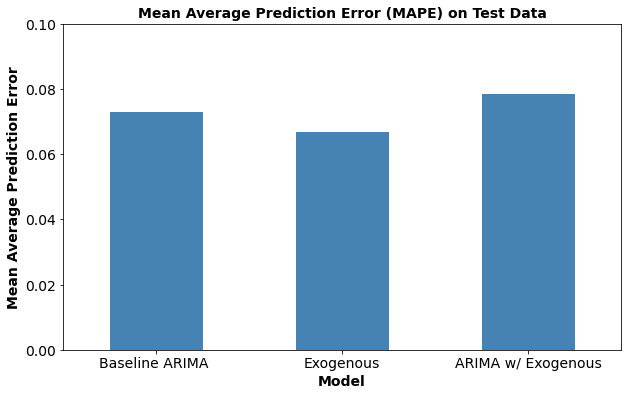

In [21]:
#Plot model selection scores (mse_mean vs rank)
label06 = ['Baseline ARIMA ','Exogenous','ARIMA w/ Exogenous']
mape06 = [df_base_pred_best['y_ape_cv'].mean(),df_exog_pred_best['y_ape_cv'].mean(),df_full_pred_best['y_ape_cv'].mean()]
df_mape06 = pd.DataFrame({'model': label06, 'mape': mape06})

#bar plot
fig06, axes06 = plt.subplots(nrows=1,ncols=1,figsize=(10,6))

df_mape06.plot.bar(ax=axes06,x='model',y='mape',rot=0,color='steelblue')
    
axes06.set_title('Mean Average Prediction Error (MAPE) on Test Data', fontsize = 14.0, fontweight='bold')
axes06.set_xlabel('Model', fontsize = 14.0, fontweight='bold')
axes06.tick_params(axis='x', labelsize=14)
axes06.set_ylabel('Mean Average Prediction Error', fontsize = 14.0, fontweight='bold') 
axes06.tick_params(axis='y', labelsize=14)
axes06.set_ylim(0,0.10)
axes06.get_legend().remove()

### <b><font color='blue'> Interpretation: All Models </font></b>
The three main models evaluated in this analysis are:
* Baseline ARIMA: ARIMA(1,1,0)
* Exogenous: ARIMA(0,1,0) with exogensous variables {'tot_bus_inv_8', 'ret_sales_2', 'pmi_man_1', 'ls_rcvbl_8'}
* ARIMA w/ Exogenous: ARIMA(1,1,0) with exogensous variables {'pmi_man_1', 'ls_rcvbl_8'}

The key results of this preprocessing and training analysis are:

<ol type="1">
   <li>All three models fit the lease delinquency rate test data similarly well, with the Mean Average Prediction Error (MAPE) ranging from about 6% to 8%.</li>
   <li>Hence, any of the three models may work similarly well for predicting lease delinquency rate in future quarters.</li>
   <li>The best-fit parameters in the models are consistent with the observed partial autocorrelations and cross correlations observed in the EDA notebook: lags 1 and 2 are important as is lag 8.</li>
    <li>Despite the similarity in fit among the models, some of the models may offer certain advantages. For example, the Baseline Model is simpler, given that it does not require additional predictor time series as exogenous variables, so it is a univariate model.  Yet, the Exogenous Model may have some additional forecasting value if lagged variables can predict future delinquency rate because a lag 8 predictor is forecasting 8 quarters forward.</li>
</ol>

   

### <b>5.2 All Models: Save Results</b>

Results are saved to Python native pickle file.

In [22]:
# **** data to save: results    >>>>   add to existing pickle
filnm02 = '../data/delinq_modelfit_results.pkl'

data_objects = [df_base_arima_cv_res,df_exog_arima_cv_res,df_full_arima_cv_res]
with open(filnm02, "wb") as f:
    pickle.dump(data_objects, f)
